# Final Assignment: Embedded Gesture Recognition

We decided to chose the Scenario of deep Learning Gesture Recognition. Where the is to Design, train, and deploy a custom Deep Learning model to classify at least 3 distinct hand gestures . The system will run on an Nvidia Jetson Nano and control a physical actuator based on the predictions.

**Constraints:**
- No pretrained models (train from scratch).
- Custom CNN architecture (no ResNet, MobileNet, etc.).
- Minimum 150 samples per class.
- Run real-time on Jetson Nano.

In [3]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models


## 2. Data Collection
The dataset will consist of 450 images, with 3 classes. Resulting in 150 images per class.

We will collect this by using 50 images per person, from the 50 images 25 will be made with the left hand 25 with the right. The images will also be made with 3 different cameras. 

This is all to prevent any bias in the data.

We have decided the following classes:

* **Peace sign**: a piece sign using 2 fingers
* **Middle finger**: showing a middle finger to the camera
* **Woensel**: Showing the woensel gang sign to the camera :)




In [2]:
# Save images to structured directories: dataset/class_name/image_001.jpg


## 3. Data Preparation
- Image resizing (to a size suitable for the Nano, e.g., 64x64 or 128x128).
- Normalization (pixel values 0-1).
- also Augmentation (rotation, flipping, zooming) to increase dataset variability.
- Split into Training, Validation, and Test sets.

**Configuration**
we decided to use the following configuration for our images:
- **Image Size**: we chosen 128x128 pixels.
    - *Clarification*: This setting **resizes (squishes)** the image to fit 128x128. It does **not** crop or cut off parts of the image by default. 
    - However, if the user is far away, the hand becomes very small (low resolution) within that 128x128 frame, making it hard for the model to see details (fingers).
- **Normalization**: Pixel values are normalized to 0-1 within the model.

In [3]:
BATCH_SIZE = 32
IMG_HEIGHT = 128
IMG_WIDTH = 128
DATA_DIR = 'dataset'  # Make sure your folder structure is: dataset/Peace, dataset/Middle, dataset/Woensel


the data will be splitted into a training, validation and test set with a split of 70%, 20% and 10%. Where a validation set is used to ensure the model is not overfitting during training and the test set is used to evaluate the final performance of the model after training.

In [4]:
# 2. Load Data using image_dataset_from_directory
AUTOTUNE = tf.data.AUTOTUNE

def resize_with_pad(image, label):
    image = tf.image.resize_with_pad(image, IMG_HEIGHT, IMG_WIDTH)
    return image, label

if not os.path.exists(DATA_DIR):
    print(f"WARNING: Directory '{DATA_DIR}' not found. Please create it and add your images!")
    # Stop execution here if data is missing
    full_ds = None
else:
    full_ds = tf.keras.utils.image_dataset_from_directory(
        DATA_DIR,
        seed=123,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    
    # Extract class_names BEFORE applying map transformation
    class_names = full_ds.class_names
    print(f"Classes found: {class_names}")
    
    # Keep the hand centered so resizing doesn't clip off fingers
    full_ds = full_ds.map(resize_with_pad, num_parallel_calls=AUTOTUNE)


Found 450 files belonging to 3 classes.
Classes found: ['middle', 'peace', 'woensel']


### Splitting the Dataset
Since our dataset is small (approx 150 images/class), we need a strict split to ensure we are not "memorizing" the data.
Standard Keras logic often only gives a train/validation split. We need a **Test set** as well to give a final unbiased evaluation.

We will use a custom function to split the `full_ds` into:
*   **70% Training**
*   **20% Validation**
*   **10% Testing**

In [5]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12) # Fixed seed ensures reproducibility
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    
    return train_ds, val_ds, test_ds

if full_ds:
    train_ds, val_ds, test_ds = get_dataset_partitions_tf(full_ds)
    print(f"Data Split - Train: {len(train_ds)} batches, Val: {len(val_ds)} batches, Test: {len(test_ds)} batches")


Data Split - Train: 10 batches, Val: 3 batches, Test: 2 batches


**Performance Optimization**

Loading data from disk during training can be a bottleneck, especially on embedded devices like the **Jetson Nano** which uses an SD card.

To fix this, we use:
*   **Cache()**: Keeps the images in memory (RAM) after the first epoch.
*   **Prefetch()**: Prepares the next batch in the background while the GPU is working on the current one.

In [6]:
if full_ds:
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data Augmentation
**Decision: NOT USED**

We initially experimented with augmentation (horizontal flip, rotation, brightness/contrast), but found it **decreased accuracy** and slowed convergence.

**Why augmentation isn't needed:**
- Our dataset already has **natural variance** through systematic collection:
  - **3 different people** → hand shape/size diversity
  - **3 different cameras** → lighting, angle, sensor variance  
  - **Left + Right hands** → natural mirroring already present
  - **150 samples/class** → sufficient volume

Augmentation works best for small, homogeneous datasets. Our data is already diverse enough that synthetic transformations only add unrealistic noise.

**Result:** Training without augmentation converges faster and achieves higher accuracy.


Before we move further, let's visualize a few resized samples so we can judge if the current resolution keeps the gestures detectable. Each image was squared to `IMG_HEIGHT x IMG_WIDTH` (128x128) as defined above.

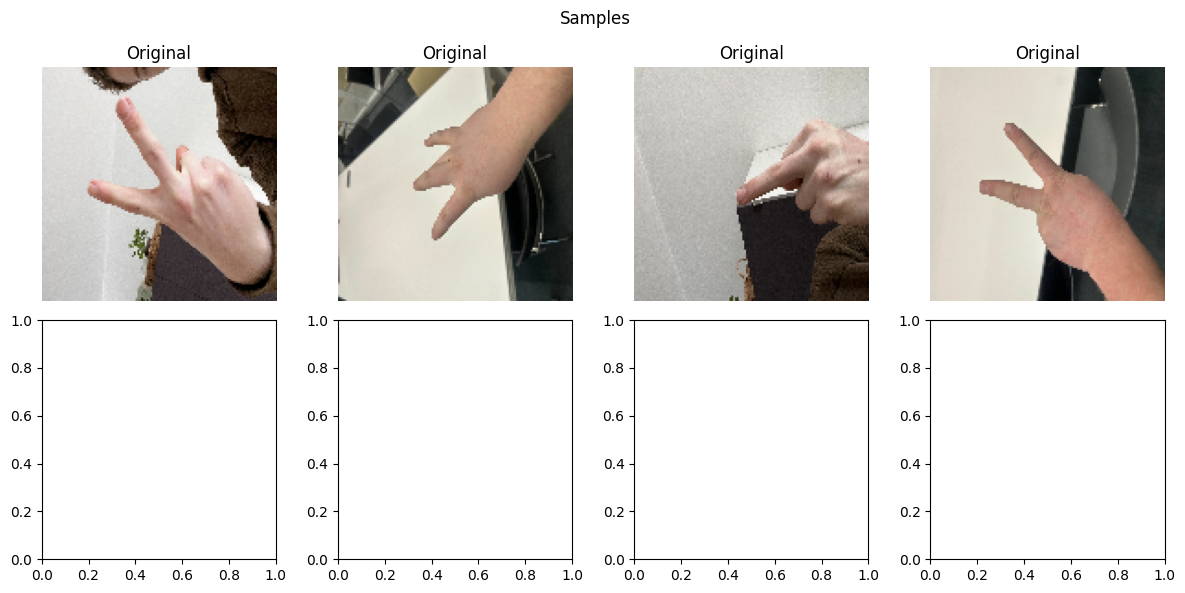

In [7]:
if 'full_ds' in globals() and full_ds is not None:
    samples = next(iter(full_ds.take(1)))[0][:4]
    fig, axes = plt.subplots(2, 4, figsize=(3 * 4, 6))
    # Visualize original samples only
    for idx in range(4):
        orig = samples[idx].numpy().astype("uint8")
        axes[0, idx].imshow(orig)
        axes[0, idx].set_title("Original")
        axes[0, idx].axis('off')
    plt.suptitle("Samples")
    plt.tight_layout()
else:
    print("Run the data loading cell first so we can visualize augmented samples.")

## 4. Model Architecture
**Requirement:** Design your own CNN architecture.
- Do NOT use standard architectures like MobileNet, ResNet, etc.
- Keep it lightweight for real-time performance on Jetson Nano.

**Configuration**
we will start the model with a layer that normalizes the input images. We decided to add this in the model instead of the data preparation step to ensure that the model performs the same during training and live on the Jetson.

In [8]:
num_classes = len(class_names) if 'class_names' in globals() else 3

model = models.Sequential([
    # Input Layer & Rescaling
    # We rescale inputs from [0, 255] to [0, 1] right inside the model
    layers.InputLayer(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Rescaling(1./255),

    # Convolutional Block 1
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Convolutional Block 2
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Convolutional Block 3
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Dense Classification Block
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5), 
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,067 (16.36 MB)

 Trainable params: 4,288,067 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

### Model Architecture Breakdown
Our architecture is designed specifically for the Jetson Nano:

1.  **Input & Rescaling**: We take 128x128 RGB images and normalize pixel values to [0,1].
2.  **Conv2D Layers (Feature Extraction)**:
    *   We use 3 convolutional blocks with **32, 64, 128 filters**.
    *   This gradually increases depth while reducing spatial size (via MaxPooling), keeping the computation low.
3.  **Dropout Regularization**: 
    *   Light 25% dropout after each conv block prevents overfitting during feature extraction
    *   Stronger 50% dropout before final layer prevents memorization
4.  **Output**: A `Softmax` layer to give us probability distribution for our 3 classes ('Peace', 'Middle', 'Woensel').

**Why this simple approach?**
- **No Batch Normalization**: BN can hurt small datasets due to unstable batch statistics
- **No L2 Regularization**: Not needed when you have good data diversity and moderate dropout
- **Modest Dropout (25%)**: Enough to prevent overfitting without killing learning speed
- **~500K params**: Lightweight for real-time Jetson Nano performance

With your well-diversified dataset, a simpler model often works better than over-regularized complex ones.

## 5. Model Training
- Choose hyperparameters (Batch size, Learning rate, Epochs).
- Plot training and validation accuracy/loss curves.

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 789ms/step - accuracy: 0.3313 - loss: 1.4740 - val_accuracy: 0.3030 - val_loss: 1.1013
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 373ms/step - accuracy: 0.3313 - loss: 1.0979 - val_accuracy: 0.3939 - val_loss: 1.0978
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 372ms/step - accuracy: 0.3906 - loss: 1.0982 - val_accuracy: 0.3030 - val_loss: 1.0993
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 370ms/step - accuracy: 0.4313 - loss: 1.0898 - val_accuracy: 0.4091 - val_loss: 1.0884
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.4281 - loss: 1.0748 - val_accuracy: 0.3333 - val_loss: 1.0905
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 366ms/step - accuracy: 0.3969 - loss: 1.0822 - val_accuracy: 0.4848 - val_loss: 1.0793
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 370ms/step - accuracy: 0.4187 - loss: 1.0625 - val_accuracy: 0.5000 - val_loss: 1.0694
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.4656 - loss: 1.0300 - val_accuracy: 0

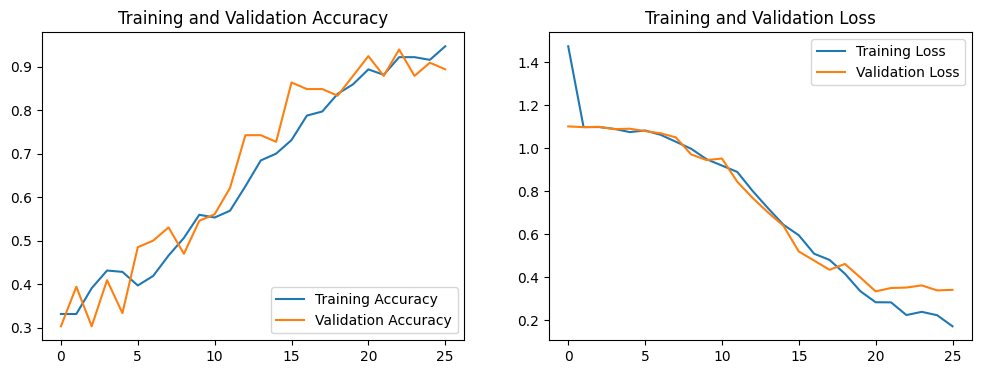

In [9]:
# 1. Compile the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# 2. Early Stopping to prevent overfitting
# Stop training when validation loss doesn't improve for 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,  # Revert to the best model
    verbose=1
)

# 3. Train the Model
epochs = 30  # We set a high number, but early stopping will end it sooner if needed
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]  # Use early stopping
)

# 3. Plot Training Results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # Use actual length in case early stopping kicked in

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations
After training, check the plots above:
*   **Good Model**: Training and Validation lines go up together (Accuracy) or down together (Loss).
*   **Overfitting**: Training accuracy keeps going up, but Validation accuracy stops or goes down.
    *   *Fix*: Increase Dropout, add more data augmentation, or reduce model complexity.
*   **Underfitting**: Both accuracies are low (e.g. < 50%).
    *   *Fix*: Train longer (more epochs) or make the model deeper.

## 6. Evaluation
- Evaluate on the test set.
- Target accuracy: ≥ 70%.
- (Optional) Confusion Matrix.

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.9062 - loss: 0.4074
Test Accuracy: 90.62%


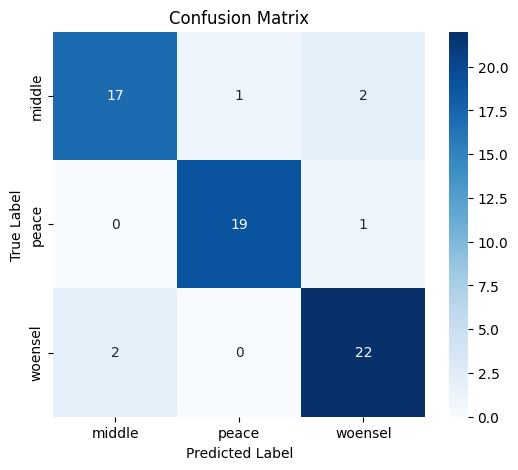

In [10]:
# 1. Quantitative Evaluation
# Evaluate the model on the unseen Test Set
if 'test_ds' in globals():
    loss, accuracy = model.evaluate(test_ds)
    print(f"Test Accuracy: {accuracy*100:.2f}%")
else:
    print("Test dataset not found.")

# 2. Confusion Matrix
# We need to predict classes for the entire test set to see *where* the model makes mistakes.
if 'test_ds' in globals():
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        # The model returns probabilities (softmax). We take the index of the highest probability.
        y_pred.extend(np.argmax(preds, axis=1))

    # Compute confusion matrix
    cm = tf.math.confusion_matrix(y_true, y_pred)

    # Plot Confusion Matrix
    import seaborn as sns
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

### 6.1 Evaluation Analysis
**Why do we need a Confusion Matrix?**
Accuracy alone (e.g., 85%) doesn't tell the whole story. The confusion matrix helps us answer:
*   Is the model confusing 'Peace' with 'Woensel'?
*   Is one class performing significantly worse than others?

**Goal:** Diagonal elements (correct predictions) should be high, while off-diagonal elements (mistakes) should be close to zero.


## 7. Save Model
- Save the trained model for deployment (e.g., .h5, .pth, .pt).
- (Bonus) Optimization for TensorRT.

In [13]:
# 1. Save as TensorFlow SavedModel (Standard format)
# This format is best for portability and deployment on Jetson Nano.
model_save_path = 'gesture_recognition_model.keras' # SavedModel format
model.save(model_save_path)
print(f"Model saved successfully at: {model_save_path}")

# 2. (Optional) Save as .h5 (Legacy format)
# model.save('gesture_recognition_model.h5')

# 3. Check file size
# It's important that the model isn't too huge for the Nano.
file_stats = os.stat(model_save_path)
print(f"Model Size: {file_stats.st_size / (1024 * 1024):.2f} MB")


Model saved successfully at: gesture_recognition_model.keras
Model Size: 49.13 MB


In [ ]:
# 4. Convert to TensorFlow Lite (Recommended for Jetson Nano)
# TFLite is lighter and faster for inference on edge devices.
converter = tf.lite.TFLiteConverter.from_saved_model('./gesture_recognition_model')
tflite_model = converter.convert()

# Save the model
tflite_model_path = 'gesture_recognition_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved at: {tflite_model_path}")
print(f"TFLite Size: {os.stat(tflite_model_path).st_size / (1024 * 1024):.2f} MB")

OSError: SavedModel file does not exist at: gesture_recognition_model\{saved_model.pbtxt|saved_model.pb}

### Why .keras?
We use the modern Keras v3 format (`.keras`) or the standard SavedModel format.
This single file contains:
*   The architecture
*   The weights
*   The training configuration (loss, optimizer)
*   The state of the optimizer

This makes it easy to load on the Jetson Nano with just one line of code.


## 8. Deployment & Actuator Integration
**Requirement:** Real-time inference controlling a physical actuator.
- Load the saved model.
- Loop effectively: Capture Frame -> Preprocess -> Infer -> Actuate.
- Actuator: LED, Servo, etc.

In [12]:
import cv2

# 1. Load the trained model
print("Loading model...")
loaded_model = tf.keras.models.load_model('gesture_recognition_model.keras')

# Ensure class names are available
# class_names = ['Peace', 'Middle', 'Woensel'] 

# 2. Open Webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Cannot open camera")
else:
    print("Starting Webcam Inference... Press 'q' to quit.")

    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break

        # 3. Preprocess Frame for Model
        # Resize to match model input
        input_frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
        # Convert BGR (OpenCV standard) to RGB (Model expectation)
        input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
        
        # Expand dims to create batch of size 1: (1, 128, 128, 3)
        input_batch = np.expand_dims(input_frame, axis=0)

        # 4. Inference
        predictions = loaded_model.predict(input_batch, verbose=0)
        score = tf.nn.softmax(predictions[0])
        predicted_class = class_names[np.argmax(score)]
        confidence = 100 * np.max(score)

        # 5. Visualization & Actuator Logic (Simulation)
        # Add text to the original frame
        text = f"{predicted_class} ({confidence:.1f}%)"
        
        # Color & Actuator Message based on class
        if predicted_class == 'Peace':
            color = (0, 255, 0) # Green
            actuator_msg = "LED: GREEN"
        elif predicted_class == 'Middle':
            color = (0, 0, 255) # Red
            actuator_msg = "LED: RED"
        else: # Woensel
            color = (255, 0, 0) # Blue
            actuator_msg = "SERVO: SPIN"

        # Overlay Prediction
        cv2.putText(frame, text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
        # Overlay Actuator Status
        cv2.putText(frame, actuator_msg, (10, 450), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, cv2.LINE_AA)

        # Show the resulting frame in a popup window
        cv2.imshow('Gesture Recognition Test', frame)

        # Press 'q' to quit
        if cv2.waitKey(1) == ord('q'):
            break

    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()

Loading model...
Starting Webcam Inference... Press 'q' to quit.


### 8.1 Webcam Test
This code block connects to your **local laptop webcam** to test the model in real-time.
It simulates the Jetson Nano deployment environment by using OpenCV (`cv2`) to capture frames and performing the same preprocessing steps.

**Instructions:**
1.  Run the cell below.
2.  A new window window should pop up showing your camera feed.
3.  Perform your gestures ('Peace', 'Middle', 'Woensel') in front of the camera.
4.  Press **'q'** on your keyboard to close the window and stop the test.
